# FairClassifierPipeline

IDC - MLOps 2021
*  Tom Saltsberg
*  Eliran Gerbi
*  Tomer Cohen

In [ ]:
! git clone https://itomco@github.com/itomco/FairClassifierPipeline.git

fatal: destination path 'FairClassifierPipeline' already exists and is not an empty directory.


In [ ]:
pip install -r 'FairClassifierPipeline/requirements.txt'

In [ ]:
#Importing required libraries
import json
import os
import pandas as pd
import numpy as np
from typing import *
from datetime import datetime
from sklearn.metrics import classification_report
from sklearn import set_config

np.random.seed(sum(map(ord, "aesthetics")))


In [ ]:
# project_folder_path = '/content/drive/MyDrive/Courses/Colab Notebooks/MLOps/Project/FairClassifierPipeline'
project_folder_path = './FairClassifierPipeline'
os.chdir(project_folder_path)

In [ ]:
!ls

BaseClassifiers  FairClassifierPipeline  main.py    requirements.txt
Configs		 gscv_results		 Notebooks  setup.py
Data		 LICENSE		 README.md


In [ ]:
print(os.getcwd())

/content/FairClassifierPipeline


In [ ]:
! python setup.py

usage: setup.py [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
   or: setup.py --help [cmd1 cmd2 ...]
   or: setup.py --help-commands
   or: setup.py cmd --help

error: no commands supplied


In [ ]:
#import FairClassifierPipeline package services
from FairClassifierPipeline import FairPipeline as fair_ppl
from FairClassifierPipeline import Utils as utils
from BaseClassifiers.BaseClf import BaseClf
from BaseClassifiers import BaseClfCreator
from FairClassifierPipeline.FairClassifier import FairClassifier
from FairClassifierPipeline import FairnessUtils as frns_utils
from Configs import Configurator as cfg
from Data import DataLoader as data_loader


import scipy.special
import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()


In [ ]:
create_config = True
if create_config:
    cfg.create_configs()


def load_config(config_name:str) -> Dict:
    with open(f'Configs/{config_name}.json', 'r', encoding='utf-8') as f:
        config_reloaded = json.load(f)
    return config_reloaded

Saving german config file ...
Saving bank config file ...


In [ ]:
project_mode = 'german'

config = load_config(config_name=project_mode)

fairness_metrics = config['fairness_metrics']
target_fairness_metric = config['target_fairness_metric']

####-1. Load data
print('\n####### I. Load Data ################################################################################################################ \n')
data = data_loader.load_data(project_mode=project_mode, data_path=config['data_path'])
print(f'{project_mode.upper()} data loaded:')
print(data.head(3))

base_clf:BaseClf = BaseClfCreator.create_base_clf(project_mode=project_mode)


####-4. search for most fairness biased sensitive feature
print('\n####### III. search for most fairness biased sensitive feature ############################################################################ \n')

sensitive_feature = FairClassifier.get_most_biased_sensitive_feature(data=data.copy(),
                                                            fairness_metric=target_fairness_metric,
                                                            base_clf=base_clf,
                                                            config=config)

print(f"Sensitive feature with highest un-fair bias based on fairness metric '{target_fairness_metric}' is: {sensitive_feature}\n\n\n ")
config['sensitive_feature'] = sensitive_feature

ppl = fair_ppl.create_pipeline(config)
set_config(display='diagram') 
ppl


####### I. Load Data ################################################################################################################ 

GERMAN data loaded:
  existingchecking  duration  ... foreignworker classification
0              A11         6  ...          A201              1
1              A12        48  ...          A201              2
2              A14        12  ...          A201              1

[3 rows x 21 columns]

####### III. search for most fairness biased sensitive feature ############################################################################ 

extract final_columns from FeatureUnion ...
extract final_columns from FeatureUnion ...
                    aod
statussex:aod  0.272989
age:aod        0.179350
Sensitive feature with highest un-fair bias based on fairness metric 'AOD' is: statussex


 


Pipeline(steps=[('remove_rows_wo_label_value',
                 FunctionTransformer(func=<function remove_rows_wo_value_for_column at 0x7f0e6c2ab440>,
                                     kw_args={'label_col_name': 'classification'})),
                ('remove_sparse_columns',
                 FunctionTransformer(func=<function remove_low_data_columns at 0x7f0e6c2ab3b0>,
                                     kw_args={'threshold': 0.8})),
                ('trim_numeric_str_stabs',
                 FunctionTransformer(f...
                                                                                             strategy='most_frequent')),
                                                                 ('ordinal_encoder',
                                                                  OrdinalCatEncoder(ordinal_cat_settings={'existingchecking': ['A14',
                                                                                                                               'A11',
                                                                                                                               'A12',
                                                                                                                               'A13'],
                                                                                                          'savings': ['A65',
                                                                                                                      'A61',
                                                                                                                      'A62',
                                                                                                                      'A63',
                                                                                                                      'A64']},
                                                                                    ordinal_cols_selector=OrdinalCategoricalColsExtractor(include_label_col=True,
                                                                                                                                          label_col_name='classification',
                                                                                                                                          must_included_cols=['statussex'],
                                                                                                                                          relevant_cols=['existingchecking',
                                                                                                                                                         'savings'])))]))]))])

In [ ]:
# title showcase pipeline impact on base model
def load_config(config_name:str) -> Dict:
    with open(f'Configs/{config_name}.json', 'r', encoding='utf-8') as f:
        config_reloaded = json.load(f)
    return config_reloaded

def showcase_pipeline_impact_on_base_model(config:Dict,
                                           fairness_metrics:List,
                                           base_clf:BaseClf,
                                           data:pd.DataFrame
                                           ):

    sensitive_features_names = config['sensitive_features']
    results = {}

    for sf in sensitive_features_names:
        print(f'Showcase pipeline impact on base model performance considering Sensitive Feature: ###- {sf.upper()} -###')

        snsftr_frns_mtrcs_w_base_preprocess = {}
        snsftr_frns_mtrcs_w_fair_pipeline = {}
        snsftr_cm_w_base_preprocess = {}
        snsftr_cm_w_fair_pipeline = {}

        config['sensitive_feature'] = sf

        #Execute Baseline XGBoost Classifier
        base_X_train, base_X_test, base_y_train, base_y_test, base_model, base_y_pred, base_y_pred_proba = \
                                                                    base_clf.run_baseline(data=data.copy(),
                                                                                          config=config)

        _, _, base_auc = utils.get_roc(y_test=base_y_test,
                                                     y_pred=base_y_pred)

        print('####### Base model ######### Confusion Matirx:')
        utils.print_confusion_matrix(base_y_test,base_y_pred, base_y_pred_proba, do_plot=True)

        clsf_rprt = classification_report(base_y_test, pd.Series(base_y_pred), digits=4, output_dict=True)
        snsftr_cm_w_base_preprocess.update({f'{sf}:accuracy': clsf_rprt['accuracy'],
                                            f"{sf}:TPR['1']": clsf_rprt['1']['recall'],
                                            f"{sf}:FPR['1']": 1-clsf_rprt['0']['recall'],
                                            f'{sf}:macro_avg-precision': clsf_rprt['macro avg']['precision'],
                                            f'{sf}:macro_avg-recall': clsf_rprt['macro avg']['recall'],
                                            f'{sf}:macro_avg-f1-score': clsf_rprt['macro avg']['f1-score'],
                                            f'{sf}:AUC': base_auc})

        if sf in data.columns and fair_ppl.is_categorial(data[sf]):
            for frns_mtrc in fairness_metrics:
                frns_mtrc = frns_mtrc.lower()
                snsftr_frns_mtrcs_w_base_preprocess.update(frns_utils.get_fairness_score_for_sensitive_features(sensitive_features_names= [sf],
                                                                                                        fairness_metric=frns_mtrc,
                                                                                                        y_true=base_y_test,
                                                                                                        y_pred=pd.Series(base_y_pred),
                                                                                                        data=base_X_test))
        else:
            # skip sensitive feature with continues values as base model's data preprocessing
            # does not convert it to categorical feature as our pipeline does
            for frns_mtrc in fairness_metrics:
                frns_mtrc = frns_mtrc.lower()
                snsftr_frns_mtrcs_w_base_preprocess[f'{sf}:{frns_mtrc}'] = -1 #not measured




        #initial
        ppl, preprocessed_train_data, preprocessed_test_data, initial_X_train, initial_X_test, initial_y_train, initial_y_test = \
                                                                                        fair_ppl.run_fair_data_preprocess_pipeline(data=data.copy(), config=config)

        #### Pipeline Stracture Graph plot
        #set_config(display='diagram')
        # ppl

        #### Execute Baseline XGBoost Classifier over fairly preprocessed data
        initial_y_test = utils.to_int_srs(initial_y_test)
        initial_model, initial_y_pred, initial_y_pred_proba = base_clf.fit_predict(X_train= utils.to_float_df(initial_X_train),
                                                                                  y_train= utils.to_int_srs(initial_y_train),
                                                                                  X_test= utils.to_float_df(initial_X_test))

        _, _, initial_auc = utils.get_roc(y_test= initial_y_test,
                                                                 y_pred= initial_y_pred)

        print('####### Initial model ######### Confusion Matirx:')
        utils.print_confusion_matrix(utils.to_int_srs(initial_y_test),initial_y_pred, initial_y_pred_proba, do_plot=True)

        clsf_rprt = classification_report(initial_y_test, pd.Series(initial_y_pred), digits=4, output_dict=True)
        snsftr_cm_w_fair_pipeline.update({f'{sf}:accuracy':clsf_rprt['accuracy'],
                                          f"{sf}:TPR['1']": clsf_rprt['1']['recall'],
                                          f"{sf}:FPR['1']": 1-clsf_rprt['0']['recall'],
                                          f'{sf}:macro_avg-precision':clsf_rprt['macro avg']['precision'],
                                          f'{sf}:macro_avg-recall':clsf_rprt['macro avg']['recall'],
                                          f'{sf}:macro_avg-f1-score':clsf_rprt['macro avg']['f1-score'],
                                          f'{sf}:AUC': initial_auc})


        for frns_mtrc in fairness_metrics:
            snsftr_frns_mtrcs_w_fair_pipeline.update(frns_utils.get_fairness_score_for_sensitive_features(sensitive_features_names = [sf],
                                                                                                  fairness_metric=frns_mtrc,
                                                                                                  y_true=initial_y_test,
                                                                                                  y_pred=pd.Series(initial_y_pred),
                                                                                                  data=initial_X_test))

        base_vs_initial_eod_results = pd.DataFrame([snsftr_frns_mtrcs_w_base_preprocess,
                                                    snsftr_frns_mtrcs_w_fair_pipeline]).T

        base_vs_initial_macro_avg_cm_resuls = pd.DataFrame([snsftr_cm_w_base_preprocess,
                                                           snsftr_cm_w_fair_pipeline]).T

        base_vs_initial_eod_results.columns = ['base','initial']
        base_vs_initial_macro_avg_cm_resuls.columns = ['base','initial']
        result = pd.concat([base_vs_initial_eod_results,base_vs_initial_macro_avg_cm_resuls],axis=0)
        print(f"Base model vs Initial model performance comparison for sensitive feature '{sf}':\n{result}")
        print('\n######################################################################################################################################\n')

        results[sf] = result

    return results


####### I. Load Data ################################################################################################################ 

BANK data loaded:
   age         job  marital  education  ... pdays  previous poutcome   y
0   30  unemployed  married    primary  ...    -1         0  unknown  no
1   33    services  married  secondary  ...   339         4  failure  no
2   35  management   single   tertiary  ...   330         1  failure  no

[3 rows x 17 columns]

####### II. Check fair pipeline impact on base model #################################################################################### 

Showcase pipeline impact on base model performance considering Sensitive Feature: ###- AGE -###
####### Base model ######### Confusion Matirx:


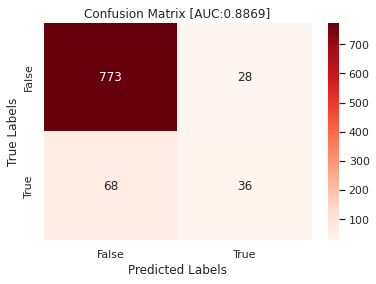

Classification Report:
              precision    recall  f1-score   support

           0     0.9191    0.9650    0.9415       801
           1     0.5625    0.3462    0.4286       104

    accuracy                         0.8939       905
   macro avg     0.7408    0.6556    0.6851       905
weighted avg     0.8782    0.8939    0.8826       905

True Positive Rate [Recall(1)]: 0.34615384615384615
False Positive Rate [1-RCL(0)]: 0.03495630461922597
Accuracy with default threshold: 89.3923%

extract final_columns from FeatureUnion ...
####### Initial model ######### Confusion Matirx:


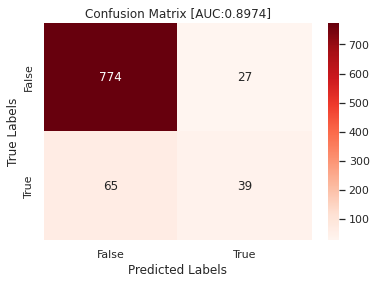

Classification Report:
              precision    recall  f1-score   support

           0     0.9225    0.9663    0.9439       801
           1     0.5909    0.3750    0.4588       104

    accuracy                         0.8983       905
   macro avg     0.7567    0.6706    0.7014       905
weighted avg     0.8844    0.8983    0.8882       905

True Positive Rate [Recall(1)]: 0.375
False Positive Rate [1-RCL(0)]: 0.033707865168539325
Accuracy with default threshold: 89.8343%

Base model vs Initial model performance comparison for sensitive feature 'age':
                             base   initial
age:aod                 -1.000000  0.458333
age:eod                 -1.000000  0.666667
age:accuracy             0.893923  0.898343
age:TPR['1']             0.346154  0.375000
age:FPR['1']             0.034956  0.033708
age:macro_avg-precision  0.740822  0.756718
age:macro_avg-recall     0.655599  0.670646
age:macro_avg-f1-score   0.685053  0.701363
age:AUC                  0.655599  0.670

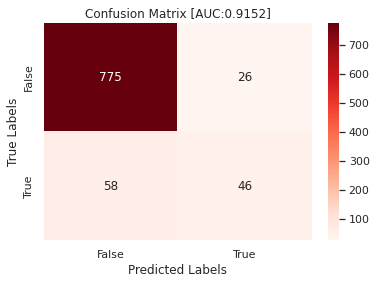

Classification Report:
              precision    recall  f1-score   support

           0     0.9304    0.9675    0.9486       801
           1     0.6389    0.4423    0.5227       104

    accuracy                         0.9072       905
   macro avg     0.7846    0.7049    0.7357       905
weighted avg     0.8969    0.9072    0.8997       905

True Positive Rate [Recall(1)]: 0.4423076923076923
False Positive Rate [1-RCL(0)]: 0.03245942571785269
Accuracy with default threshold: 90.7182%

extract final_columns from FeatureUnion ...
####### Initial model ######### Confusion Matirx:


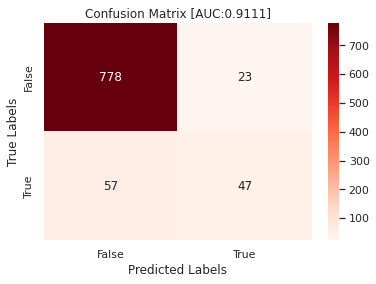

Classification Report:
              precision    recall  f1-score   support

           0     0.9317    0.9713    0.9511       801
           1     0.6714    0.4519    0.5402       104

    accuracy                         0.9116       905
   macro avg     0.8016    0.7116    0.7457       905
weighted avg     0.9018    0.9116    0.9039       905

True Positive Rate [Recall(1)]: 0.4519230769230769
False Positive Rate [1-RCL(0)]: 0.02871410736579276
Accuracy with default threshold: 91.1602%

Base model vs Initial model performance comparison for sensitive feature 'marital':
                                 base   initial
marital:aod                  0.116966  0.124949
marital:eod                  0.218615  0.218615
marital:accuracy             0.907182  0.911602
marital:TPR['1']             0.442308  0.451923
marital:FPR['1']             0.032459  0.028714
marital:macro_avg-precision  0.784631  0.801583
marital:macro_avg-recall     0.704924  0.711604
marital:macro_avg-f1-score   0.73566

100%|██████████| 360/360 [32:30<00:00,  5.42s/it]


Gridsearch_cv total run time: 0:32:30.593572
results:
    mean_fit_time  std_fit_time  ...  std_test_f1_macro  rank_test_f1_macro
0        1.695364      0.930256  ...           0.025432                  47
1        1.057980      0.011021  ...           0.045355                  38
2        0.935453      0.010348  ...           0.025056                  11
3        0.916994      0.009335  ...           0.041091                   1
4        0.943414      0.018962  ...           0.031868                  13
..            ...           ...  ...                ...                 ...
67       0.627878      0.008405  ...           0.023712                  45
68      13.428391      0.147080  ...           0.029114                  68
69      13.346024      0.107111  ...           0.014220                  67
70      26.221567      0.199039  ...           0.014055                  49
71      26.226052      0.115978  ...           0.032264                  65

[72 rows x 38 columns]

####### V

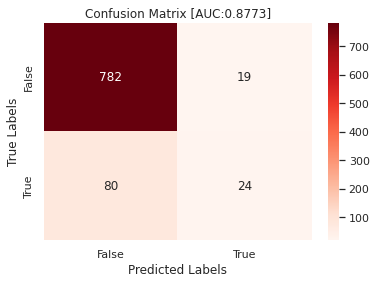

Classification Report:
              precision    recall  f1-score   support

           0     0.9072    0.9763    0.9405       801
           1     0.5581    0.2308    0.3265       104

    accuracy                         0.8906       905
   macro avg     0.7327    0.6035    0.6335       905
weighted avg     0.8671    0.8906    0.8699       905

True Positive Rate [Recall(1)]: 0.23076923076923078
False Positive Rate [1-RCL(0)]: 0.02372034956304619
Accuracy with default threshold: 89.0608%

                             base   initial   FairClf
age:aod                 -1.000000  0.458333  0.190430
age:eod                 -1.000000  0.666667  0.347826
age:accuracy             0.893923  0.898343  0.890608
age:TPR['1']             0.346154  0.375000  0.230769
age:FPR['1']             0.034956  0.033708  0.023720
age:macro_avg-precision  0.740822  0.756718  0.732666
age:macro_avg-recall     0.655599  0.670646  0.603524
age:macro_avg-f1-score   0.685053  0.701363  0.633500
age:AUC          

In [ ]:
project_mode = 'bank'

config = load_config(config_name=project_mode)

fairness_metrics = config['fairness_metrics']
target_fairness_metric = config['target_fairness_metric']

####-1. Load data
print('\n####### I. Load Data ################################################################################################################ \n')
data = data_loader.load_data(project_mode=project_mode, data_path=config['data_path'])
print(f'{project_mode.upper()} data loaded:')
print(data.head(3))

base_clf:BaseClf = BaseClfCreator.create_base_clf(project_mode=project_mode)

####-2. Check fair pipeline impact on base model
print('\n####### II. Check fair pipeline impact on base model #################################################################################### \n')
base_vs_initial_macro_avg_cm_results = showcase_pipeline_impact_on_base_model(config=config,
                                    fairness_metrics = fairness_metrics,
                                    base_clf=base_clf,
                                    data=data.copy())

####-4. search for most fairness biased sensitive feature
print('\n####### III. search for most fairness biased sensitive feature ############################################################################ \n')

sensitive_feature = FairClassifier.get_most_biased_sensitive_feature(data=data.copy(),
                                                            fairness_metric=target_fairness_metric,
                                                            base_clf=base_clf,
                                                            config=config)

print(f"Sensitive feature with highest un-fair bias based on fairness metric '{target_fairness_metric}' is: {sensitive_feature} ")


####-5. find privileged and unprivileged groups in sensitive feature
print('\n####### IV. find privileged and unprivileged groups in sensitive feature ################################################################### \n')

config = load_config(config_name=project_mode)
config['sensitive_feature'] = sensitive_feature

ppl, preprocessed_train_data, preprocessed_test_data, X_train, X_test, y_train, y_test = \
                                                    fair_ppl.run_fair_data_preprocess_pipeline(data=data.copy(), config=config)

X_train = utils.to_float_df(X_train)
y_train = utils.to_int_srs(y_train)
X_test = utils.to_float_df(X_test)
y_test = utils.to_int_srs(y_test)

xgb_clf = base_clf.fit(X_train=X_train,
                    y_train=y_train,
                    X_test=X_test)

y_pred, y_pred_proba = base_clf.predict(clf=xgb_clf,
                                            X=X_train)
y_pred = utils.to_int_srs(pd.Series(y_pred))

sensitive_feature_srs = frns_utils.get_feature_col_from_preprocessed_data(feature_name=sensitive_feature,
                                                                    data= X_train)
snsftr_groups_slctnrt, snsftr_slctrt_sub_groups = \
frns_utils.get_feature_sub_groups_by_selection_rate( y_true= y_train,
                                                        y_pred= y_pred,
                                                        sensitive_feature_srs = sensitive_feature_srs)
unprev_size = len(sensitive_feature_srs[sensitive_feature_srs.isin(pd.Series(list(snsftr_slctrt_sub_groups[0])))])
prev_size = len(sensitive_feature_srs[sensitive_feature_srs.isin(pd.Series(list(snsftr_slctrt_sub_groups[1])))])
snsftr_sub_groups = ((unprev_size,snsftr_slctrt_sub_groups[0]),(prev_size,snsftr_slctrt_sub_groups[1]))

print(f"snsftr_slctrt_sub_groups: prev=[{snsftr_slctrt_sub_groups[1]},{prev_size}], unprev=[{snsftr_slctrt_sub_groups[0]},{unprev_size}]\n")
print(f"snsftr_groups_slctnrt:\n{snsftr_groups_slctnrt}\n")

####-6. run gridsearch_cv with anomaly samples removal
print('\n####### V. Create & Fit a FairClassifier model ################################################################################################ \n')
fair_clf = FairClassifier(target_fairness_metric = target_fairness_metric,
                        base_clf=base_clf,
                        verbose=False)

fair_clf.fit(X_train = X_train,
            y_train = y_train,
            sensitive_feature_name=sensitive_feature,
            snsftr_slctrt_sub_groups=snsftr_sub_groups)

pipe_cv = fair_clf.pipe_cv
results = pd.DataFrame(pipe_cv.cv_results_)
datetime_tag = datetime.now().strftime("%y%m%d_%H%M%S")
utils.save_df(file_path = f'./gscv_results/{datetime_tag}_{project_mode}_{target_fairness_metric}_pipe_cv.cv_results_.csv',df = results)
print(f'results:\n{results}')

fair_clf_y_pred = fair_clf.predict(X_test)
fair_clf_y_pred_proba = fair_clf.predict_proba(X_test)

# best_clf_model_fair_metric_value = frns_utils.get_fairness_score_for_sensitive_features(sensitive_features_names=[sensitive_feature],
#                                                                    fairness_metric=target_fairness_metric,
#                                                                    y_true=y_test,
#                                                                    y_pred=fair_clf_y_pred,
#                                                                    data=X_test)
#
# print(f"best_fair_clf_model: {best_clf_model_fair_metric_value}")
# print(classification_report(y_test, pd.Series(y_pred), digits=4))



####-7. Check top fairness aware models' performance on un-seen (Test) data
print("\n####### VI. Check top fairness aware models' performance on un-seen (Test) data #################################################################### \n")
top_models_scores_on_test = fair_clf.retrain_top_models_and_get_performance_metrics(X_train=X_train,
                                                                                y_train=y_train,
                                                                                X_test=X_test,
                                                                                y_test=y_test,
                                                                                max_num_top_models=180,
                                                                                target_metrics_thresholds={target_fairness_metric:1.0,
                                                                                                            'f1_macro':0.0})



top_models_scores_on_test_df = pd.DataFrame(top_models_scores_on_test).sort_values(by=[target_fairness_metric.lower(),'f1_macro'], ignore_index=True)
print(top_models_scores_on_test_df.head(10))
utils.save_df(file_path = f'./gscv_results/{datetime_tag}_{project_mode}_{target_fairness_metric}_top_models_scores_on_test_df.csv',df = top_models_scores_on_test_df)


####-8. print faire classifier final results
_, _, fair_clf_auc = utils.get_roc(y_test= y_test,
                                y_pred= fair_clf_y_pred)

print('\n\n####### Fair Classifier model ######### Confusion Matirx:')
utils.print_confusion_matrix(y_test,fair_clf_y_pred, fair_clf_y_pred_proba, do_plot=True)


best_fair_clf_aod = top_models_scores_on_test_df['aod'][0]
best_fair_clf_eod = top_models_scores_on_test_df['eod'][0]
fair_clf_results = {f'{sensitive_feature}:aod':best_fair_clf_aod, f'{sensitive_feature}:eod':best_fair_clf_eod}

clsf_rprt = classification_report(y_test, pd.Series(fair_clf_y_pred), digits=4, output_dict=True)
fair_clf_results.update({f'{sensitive_feature}:accuracy':clsf_rprt['accuracy'],
                    f"{sensitive_feature}:TPR['1']": clsf_rprt['1']['recall'],
                    f"{sensitive_feature}:FPR['1']": 1-clsf_rprt['0']['recall'],
                    f'{sensitive_feature}:macro_avg-precision':clsf_rprt['macro avg']['precision'],
                    f'{sensitive_feature}:macro_avg-recall':clsf_rprt['macro avg']['recall'],
                    f'{sensitive_feature}:macro_avg-f1-score':clsf_rprt['macro avg']['f1-score'],
                    f'{sensitive_feature}:AUC': fair_clf_auc})

base_vs_initial_vs_fair_clf = base_vs_initial_macro_avg_cm_results[sensitive_feature].copy()
base_vs_initial_vs_fair_clf['FairClf'] = pd.Series(fair_clf_results)

print(base_vs_initial_vs_fair_clf)

print('\n\n####################################################################################################################################\n\n')



####### I. Load Data ################################################################################################################ 

GERMAN data loaded:
  existingchecking  duration  ... foreignworker classification
0              A11         6  ...          A201              1
1              A12        48  ...          A201              2
2              A14        12  ...          A201              1

[3 rows x 21 columns]

####### II. Check fair pipeline impact on base model #################################################################################### 

Showcase pipeline impact on base model performance considering Sensitive Feature: ###- STATUSSEX -###
####### Base model ######### Confusion Matirx:


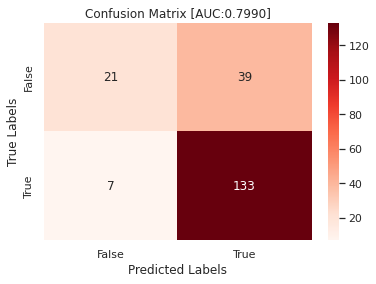

Classification Report:
              precision    recall  f1-score   support

           0     0.7500    0.3500    0.4773        60
           1     0.7733    0.9500    0.8526       140

    accuracy                         0.7700       200
   macro avg     0.7616    0.6500    0.6649       200
weighted avg     0.7663    0.7700    0.7400       200

True Positive Rate [Recall(1)]: 0.95
False Positive Rate [1-RCL(0)]: 0.65
Accuracy with default threshold: 77.0000%

extract final_columns from FeatureUnion ...
####### Initial model ######### Confusion Matirx:


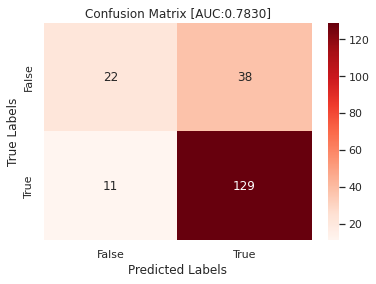

Classification Report:
              precision    recall  f1-score   support

           0     0.6667    0.3667    0.4731        60
           1     0.7725    0.9214    0.8404       140

    accuracy                         0.7550       200
   macro avg     0.7196    0.6440    0.6568       200
weighted avg     0.7407    0.7550    0.7302       200

True Positive Rate [Recall(1)]: 0.9214285714285714
False Positive Rate [1-RCL(0)]: 0.6333333333333333
Accuracy with default threshold: 75.5000%

Base model vs Initial model performance comparison for sensitive feature 'statussex':
                                   base   initial
statussex:aod                  0.307471  0.290230
statussex:eod                  0.448276  0.413793
statussex:accuracy             0.770000  0.755000
statussex:TPR['1']             0.950000  0.921429
statussex:FPR['1']             0.650000  0.633333
statussex:macro_avg-precision  0.761628  0.719561
statussex:macro_avg-recall     0.650000  0.644048
statussex:macro_avg

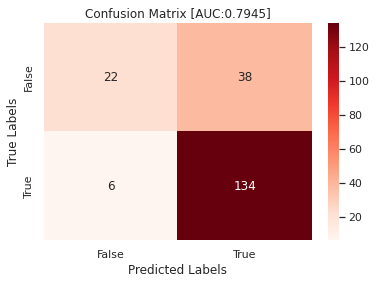

Classification Report:
              precision    recall  f1-score   support

           0     0.7857    0.3667    0.5000        60
           1     0.7791    0.9571    0.8590       140

    accuracy                         0.7800       200
   macro avg     0.7824    0.6619    0.6795       200
weighted avg     0.7811    0.7800    0.7513       200

True Positive Rate [Recall(1)]: 0.9571428571428572
False Positive Rate [1-RCL(0)]: 0.6333333333333333
Accuracy with default threshold: 78.0000%

extract final_columns from FeatureUnion ...
####### Initial model ######### Confusion Matirx:


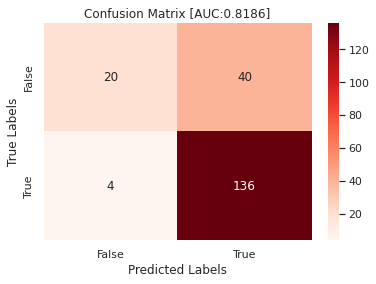

Classification Report:
              precision    recall  f1-score   support

           0     0.8333    0.3333    0.4762        60
           1     0.7727    0.9714    0.8608       140

    accuracy                         0.7800       200
   macro avg     0.8030    0.6524    0.6685       200
weighted avg     0.7909    0.7800    0.7454       200

True Positive Rate [Recall(1)]: 0.9714285714285714
False Positive Rate [1-RCL(0)]: 0.6666666666666666
Accuracy with default threshold: 78.0000%

Base model vs Initial model performance comparison for sensitive feature 'age':
                             base   initial
age:aod                 -1.000000  0.163462
age:eod                 -1.000000  0.288462
age:accuracy             0.780000  0.780000
age:TPR['1']             0.957143  0.971429
age:FPR['1']             0.633333  0.666667
age:macro_avg-precision  0.782392  0.803030
age:macro_avg-recall     0.661905  0.652381
age:macro_avg-f1-score   0.679487  0.668475
age:AUC                  0.66

100%|██████████| 360/360 [18:46<00:00,  3.13s/it]


Gridsearch_cv total run time: 0:18:46.103165
results:
    mean_fit_time  std_fit_time  ...  std_test_f1_macro  rank_test_f1_macro
0        0.855759      0.295778  ...           0.049356                  27
1        0.699198      0.011587  ...           0.048335                  53
2        0.365455      0.009074  ...           0.036461                   3
3        0.358855      0.006451  ...           0.036609                  14
4        0.366754      0.008068  ...           0.029395                   6
..            ...           ...  ...                ...                 ...
67       0.390160      0.022745  ...           0.025735                  34
68       7.080974      0.155773  ...           0.026791                  42
69       7.016850      0.048443  ...           0.037400                  59
70      13.863533      0.118055  ...           0.025232                  29
71      13.866484      0.093873  ...           0.052801                  68

[72 rows x 38 columns]

####### V

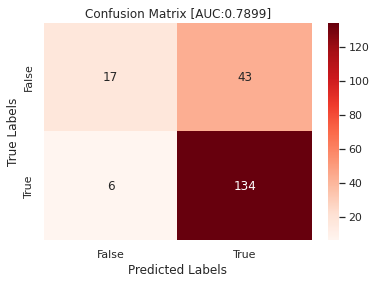

Classification Report:
              precision    recall  f1-score   support

           0     0.7391    0.2833    0.4096        60
           1     0.7571    0.9571    0.8454       140

    accuracy                         0.7550       200
   macro avg     0.7481    0.6202    0.6275       200
weighted avg     0.7517    0.7550    0.7147       200

True Positive Rate [Recall(1)]: 0.9571428571428572
False Positive Rate [1-RCL(0)]: 0.7166666666666667
Accuracy with default threshold: 75.5000%

                                   base   initial   FairClf
statussex:aod                  0.307471  0.290230  0.108333
statussex:eod                  0.448276  0.413793  0.166667
statussex:accuracy             0.770000  0.755000  0.755000
statussex:TPR['1']             0.950000  0.921429  0.957143
statussex:FPR['1']             0.650000  0.633333  0.716667
statussex:macro_avg-precision  0.761628  0.719561  0.748096
statussex:macro_avg-recall     0.650000  0.644048  0.620238
statussex:macro_avg-f1-sc

In [ ]:
project_mode = 'german'

config = load_config(config_name=project_mode)

fairness_metrics = config['fairness_metrics']
target_fairness_metric = config['target_fairness_metric']

####-1. Load data
print('\n####### I. Load Data ################################################################################################################ \n')
data = data_loader.load_data(project_mode=project_mode, data_path=config['data_path'])
print(f'{project_mode.upper()} data loaded:')
print(data.head(3))

base_clf:BaseClf = BaseClfCreator.create_base_clf(project_mode=project_mode)

####-2. Check fair pipeline impact on base model
print('\n####### II. Check fair pipeline impact on base model #################################################################################### \n')
base_vs_initial_macro_avg_cm_results = showcase_pipeline_impact_on_base_model(config=config,
                                    fairness_metrics = fairness_metrics,
                                    base_clf=base_clf,
                                    data=data.copy())

####-4. search for most fairness biased sensitive feature
print('\n####### III. search for most fairness biased sensitive feature ############################################################################ \n')

sensitive_feature = FairClassifier.get_most_biased_sensitive_feature(data=data.copy(),
                                                            fairness_metric=target_fairness_metric,
                                                            base_clf=base_clf,
                                                            config=config)

print(f"Sensitive feature with highest un-fair bias based on fairness metric '{target_fairness_metric}' is: {sensitive_feature} ")


####-5. find privileged and unprivileged groups in sensitive feature
print('\n####### IV. find privileged and unprivileged groups in sensitive feature ################################################################### \n')

config = load_config(config_name=project_mode)
config['sensitive_feature'] = sensitive_feature

ppl, preprocessed_train_data, preprocessed_test_data, X_train, X_test, y_train, y_test = \
                                                    fair_ppl.run_fair_data_preprocess_pipeline(data=data.copy(), config=config)

X_train = utils.to_float_df(X_train)
y_train = utils.to_int_srs(y_train)
X_test = utils.to_float_df(X_test)
y_test = utils.to_int_srs(y_test)

xgb_clf = base_clf.fit(X_train=X_train,
                    y_train=y_train,
                    X_test=X_test)

y_pred, y_pred_proba = base_clf.predict(clf=xgb_clf,
                                            X=X_train)
y_pred = utils.to_int_srs(pd.Series(y_pred))

sensitive_feature_srs = frns_utils.get_feature_col_from_preprocessed_data(feature_name=sensitive_feature,
                                                                    data= X_train)
snsftr_groups_slctnrt, snsftr_slctrt_sub_groups = \
frns_utils.get_feature_sub_groups_by_selection_rate( y_true= y_train,
                                                        y_pred= y_pred,
                                                        sensitive_feature_srs = sensitive_feature_srs)
unprev_size = len(sensitive_feature_srs[sensitive_feature_srs.isin(pd.Series(list(snsftr_slctrt_sub_groups[0])))])
prev_size = len(sensitive_feature_srs[sensitive_feature_srs.isin(pd.Series(list(snsftr_slctrt_sub_groups[1])))])
snsftr_sub_groups = ((unprev_size,snsftr_slctrt_sub_groups[0]),(prev_size,snsftr_slctrt_sub_groups[1]))

print(f"snsftr_slctrt_sub_groups: prev=[{snsftr_slctrt_sub_groups[1]},{prev_size}], unprev=[{snsftr_slctrt_sub_groups[0]},{unprev_size}]\n")
print(f"snsftr_groups_slctnrt:\n{snsftr_groups_slctnrt}\n")

####-6. run gridsearch_cv with anomaly samples removal
print('\n####### V. Create & Fit a FairClassifier model ################################################################################################ \n')
fair_clf = FairClassifier(target_fairness_metric = target_fairness_metric,
                        base_clf=base_clf,
                        verbose=False)

fair_clf.fit(X_train = X_train,
            y_train = y_train,
            sensitive_feature_name=sensitive_feature,
            snsftr_slctrt_sub_groups=snsftr_sub_groups)

pipe_cv = fair_clf.pipe_cv
results = pd.DataFrame(pipe_cv.cv_results_)
datetime_tag = datetime.now().strftime("%y%m%d_%H%M%S")
utils.save_df(file_path = f'./gscv_results/{datetime_tag}_{project_mode}_{target_fairness_metric}_pipe_cv.cv_results_.csv',df = results)

print(f'results:\n{results}')

fair_clf_y_pred = fair_clf.predict(X_test)
fair_clf_y_pred_proba = fair_clf.predict_proba(X_test)

# best_clf_model_fair_metric_value = frns_utils.get_fairness_score_for_sensitive_features(sensitive_features_names=[sensitive_feature],
#                                                                    fairness_metric=target_fairness_metric,
#                                                                    y_true=y_test,
#                                                                    y_pred=fair_clf_y_pred,
#                                                                    data=X_test)
#
# print(f"best_fair_clf_model: {best_clf_model_fair_metric_value}")
# print(classification_report(y_test, pd.Series(y_pred), digits=4))



####-7. Check top fairness aware models' performance on un-seen (Test) data
print("\n####### VI. Check top fairness aware models' performance on un-seen (Test) data #################################################################### \n")
top_models_scores_on_test = fair_clf.retrain_top_models_and_get_performance_metrics(X_train=X_train,
                                                                                y_train=y_train,
                                                                                X_test=X_test,
                                                                                y_test=y_test,
                                                                                max_num_top_models=180,
                                                                                target_metrics_thresholds={target_fairness_metric:1.0,
                                                                                                            'f1_macro':0.0})



top_models_scores_on_test_df = pd.DataFrame(top_models_scores_on_test).sort_values(by=[target_fairness_metric.lower(),'f1_macro'], ignore_index=True)
print(top_models_scores_on_test_df.head(10))
utils.save_df(file_path = f'./gscv_results/{datetime_tag}_{project_mode}_{target_fairness_metric}_top_models_scores_on_test_df.csv',df = top_models_scores_on_test_df)


####-8. print faire classifier final results
_, _, fair_clf_auc = utils.get_roc(y_test= y_test,
                                y_pred= fair_clf_y_pred)

print('\n\n####### Fair Classifier model ######### Confusion Matirx:')
utils.print_confusion_matrix(y_test,fair_clf_y_pred, fair_clf_y_pred_proba, do_plot=True)


best_fair_clf_aod = top_models_scores_on_test_df['aod'][0]
best_fair_clf_eod = top_models_scores_on_test_df['eod'][0]
fair_clf_results = {f'{sensitive_feature}:aod':best_fair_clf_aod, f'{sensitive_feature}:eod':best_fair_clf_eod}

clsf_rprt = classification_report(y_test, pd.Series(fair_clf_y_pred), digits=4, output_dict=True)
fair_clf_results.update({f'{sensitive_feature}:accuracy':clsf_rprt['accuracy'],
                    f"{sensitive_feature}:TPR['1']": clsf_rprt['1']['recall'],
                    f"{sensitive_feature}:FPR['1']": 1-clsf_rprt['0']['recall'],
                    f'{sensitive_feature}:macro_avg-precision':clsf_rprt['macro avg']['precision'],
                    f'{sensitive_feature}:macro_avg-recall':clsf_rprt['macro avg']['recall'],
                    f'{sensitive_feature}:macro_avg-f1-score':clsf_rprt['macro avg']['f1-score'],
                    f'{sensitive_feature}:AUC': fair_clf_auc})

base_vs_initial_vs_fair_clf = base_vs_initial_macro_avg_cm_results[sensitive_feature].copy()
base_vs_initial_vs_fair_clf['FairClf'] = pd.Series(fair_clf_results)

print(base_vs_initial_vs_fair_clf)

print('\n\n####################################################################################################################################\n\n')


In [ ]:
def load_test_results(file:str)-> pd.DataFrame:
    data = pd.read_csv(file)

    data['eod'] = abs(data['eod'])
    data['aod'] = abs(data['aod'])

    return data

def load_pipe_cv_scores(file:str)-> pd.DataFrame:
    data = pd.read_csv(file)

    data['mean_test_aod'] = abs(data['mean_test_aod'])
    data['mean_test_eod'] = abs(data['mean_test_eod'])

    return data

datetime_tag_german="220104_001933"
datetime_tag_bank="220103_235338"

path = './gscv_results/'
file_top_scores_german = os.path.join(path, f'{datetime_tag_german}_german_AOD_top_models_scores_on_test_df.csv')
file_top_scores_bank = os.path.join(path, f'{datetime_tag_bank}_bank_AOD_top_models_scores_on_test_df.csv')

data_top_results_german = load_test_results(file_top_scores_german)
data_top_results_bank = load_test_results(file_top_scores_bank)

file_pipe_cv_german = os.path.join(path,f'{datetime_tag_german}_german_AOD_pipe_cv.cv_results_.csv')
file_pipe_cv_bank = os.path.join(path, f'{datetime_tag_bank}_bank_AOD_pipe_cv.cv_results_.csv')

data_pipe_cv_german = load_pipe_cv_scores(file_pipe_cv_german)
data_pipe_cv_bank = load_pipe_cv_scores(file_pipe_cv_bank)

In [ ]:
# ##########################################################################
# GERMAN CREDIT
# ##########################################################################

#                                    base   initial   FairClf
# statussex:aod                  0.307471  0.290230  0.108333
# statussex:eod                  0.448276  0.413793  0.166667
# statussex:accuracy             0.770000  0.755000  0.755000
# statussex:TPR['1']             0.950000  0.921429  0.957143
# statussex:FPR['1']             0.650000  0.633333  0.716667
# statussex:macro_avg-precision  0.761628  0.719561  0.748096
# statussex:macro_avg-recall     0.650000  0.644048  0.620238
# statussex:macro_avg-f1-score   0.664918  0.656755  0.627532
# statussex:AUC                  0.650000  0.644048  0.620238

german_baseline = {}
german_baseline['f1_macro'] = 0.664918
german_baseline['eod'] = 0.448276
german_baseline['aod'] = 0.307471

# ##########################################################################


# ##########################################################################
# BANK
# ##########################################################################
#                              base   initial   FairClf
# age:aod                 -1.000000  0.458333  0.190430
# age:eod                 -1.000000  0.666667  0.347826
# age:accuracy             0.893923  0.898343  0.890608
# age:TPR['1']             0.346154  0.375000  0.230769
# age:FPR['1']             0.034956  0.033708  0.023720
# age:macro_avg-precision  0.740822  0.756718  0.732666
# age:macro_avg-recall     0.655599  0.670646  0.603524
# age:macro_avg-f1-score   0.685053  0.701363  0.633500
# age:AUC                  0.655599  0.670646  0.603524

bank_baseline = {}
bank_baseline['f1_macro'] = 0.685053
bank_baseline['eod'] = 0.666667
bank_baseline['aod'] = 0.458333
# ##########################################################################

In [ ]:
# add algorithm column to top results
data_top_results_bank['algorithm'] = None
data_top_results_german['algorithm'] = None
for index, row in data_top_results_bank.iterrows():
    data_top_results_bank['algorithm'].iloc[index] = data_pipe_cv_bank.loc[int(row['index']),'param_fairxgboost__anomaly_model_params']
    data_top_results_bank['algorithm'].iloc[index] = list(ast.literal_eval(data_top_results_bank['algorithm'].iloc[index]).keys())[0]

for index, row in data_top_results_german.iterrows():
    data_top_results_german['algorithm'].iloc[index] = data_pipe_cv_german.loc[int(row['index']),'param_fairxgboost__anomaly_model_params']
    data_top_results_german['algorithm'].iloc[index] = list(ast.literal_eval(data_top_results_german['algorithm'].iloc[index]).keys())[0]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
def plot_best_models(data:pd.DataFrame, baseline:Dict=None, sensitive_metric:str=None):

    data['bad_results'] = np.where((data['f1_macro'] < baseline['f1_macro']) & (data[sensitive_metric] >= baseline[sensitive_metric]), 1, 0)
    data['improved_f1'] = np.where((data['f1_macro'] >= baseline['f1_macro']) & (data[sensitive_metric] >= baseline[sensitive_metric]), 1, 0)
    data['improved_sf'] = np.where((data[sensitive_metric] < baseline[sensitive_metric]) & (data['f1_macro'] < baseline['f1_macro']), 1, 0)
    data['improved_both'] = np.where((data['f1_macro'] >= baseline['f1_macro']) & (data[sensitive_metric] < baseline[sensitive_metric]), 1, 0)

    # Make figure
    p = bokeh.plotting.figure(
        width=1500,
        height=550,
        x_axis_label='f1_macro',
        y_axis_label=sensitive_metric,
        tooltips=[('aod', '@{aod}'),
                ('eod', '@{eod}'),
                ('f1_macro', '@{f1_macro}'),
                ('tpr_diff', '@{tpr_diff}'),
                ('fpr_diff', '@{fpr_diff}'),
                ('algorithm', '@{algorithm}')],
    )

    p.circle(
        source=data[data['bad_results'] == 1],
        size=20,
        alpha=0.5, 
        x='f1_macro', 
        y=sensitive_metric, 
        color="red",
        legend_label="bad results",
    )

    p.circle(
        source=data[data['improved_f1'] == 1], 
        size=20,
        alpha=0.5,         
        x='f1_macro', 
        y=sensitive_metric, 
        color="orange",
        legend_label="improved f1",
    )

    p.circle(
        source=data[data['improved_sf'] == 1], 
        size=20,
        alpha=0.5,         
        x='f1_macro', 
        y=sensitive_metric, 
        color="blue",
        legend_label=f"improved {sensitive_metric}",
    )

    p.circle(
        source=data[data['improved_both'] == 1], 
        size=20,
        alpha=0.5,         
        x='f1_macro', 
        y=sensitive_metric, 
        color="green",
        legend_label="improved both",
    )

    p.legend.location = "top_left"
    p.legend.click_policy = "hide"

    bokeh.io.show(p)

In [ ]:
def plot_improved_results(data:pd.DataFrame, baseline:Dict=None, sensitive_metric:str=None, focus_on:str=None):

    data['bad_results'] = np.where((data['f1_macro'] < baseline['f1_macro']) & (data[sensitive_metric] >= baseline[sensitive_metric]), 1, 0)
    data['improved_f1'] = np.where((data['f1_macro'] >= baseline['f1_macro']) & (data[sensitive_metric] >= baseline[sensitive_metric]), 1, 0)
    data['improved_sf'] = np.where((data[sensitive_metric] < baseline[sensitive_metric]) & (data['f1_macro'] < baseline['f1_macro']), 1, 0)
    data['improved_both'] = np.where((data['f1_macro'] >= baseline['f1_macro']) & (data[sensitive_metric] < baseline[sensitive_metric]), 1, 0)

    # Make figure
    p = bokeh.plotting.figure(
        width=1500,
        height=550,
        x_axis_label='f1_macro',
        y_axis_label=sensitive_metric,
        tooltips=[('aod', '@{aod}'),
                ('eod', '@{eod}'),
                ('f1_macro', '@{f1_macro}'),
                ('tpr_diff', '@{tpr_diff}'),
                ('fpr_diff', '@{fpr_diff}'),
                ('algorithm', '@{algorithm}')]
    )
    
    p.circle(
        source=data[(data[focus_on] == 1) & (data['algorithm'] == "RC")], 
        size=20,
        alpha=0.5,         
        x='f1_macro', 
        y=sensitive_metric, 
        color="orange",
        legend_label="RC",
    )

    p.circle(
        source=data[(data[focus_on] == 1) & (data['algorithm'] == "SVM")], 
        size=20,
        alpha=0.5,         
        x='f1_macro', 
        y=sensitive_metric, 
        color="purple",
        legend_label="SVM",
    )

    p.circle(
        source=data[(data[focus_on] == 1) & (data['algorithm'] == "LOF")], 
        size=20,
        alpha=0.5,         
        x='f1_macro', 
        y=sensitive_metric, 
        color="olive",
        legend_label="LOF",
    )

    p.circle(
        source=data[(data[focus_on] == 1) & (data['algorithm'] == "IF")], 
        size=20,
        alpha=0.5,        
        x='f1_macro', 
        y=sensitive_metric, 
        color="cyan",
        legend_label="IF",
    )

    p.circle(
        source=data[(data[focus_on] == 1) & (data['algorithm'] == "RRCF")], 
        size=20,
        alpha=0.5,         
        x='f1_macro', 
        y=sensitive_metric, 
        color="royalblue",
        legend_label="RRCF",
    )

    p.legend.location = "top_left"
    p.legend.click_policy = "hide"

    bokeh.io.show(p)

# German Credit Best Results

In [ ]:
plot_best_models(data_top_results_german.copy(), german_baseline, 'aod')

In [ ]:
lot_improved_results(data_top_results_german.copy(), german_baseline, 'aod','improved_sf')

# Bank Best Results

In [ ]:
plot_best_models(data_top_results_bank.copy(), bank_baseline, 'eod')

In [ ]:
plot_improved_results(data_top_results_bank.copy(), bank_baseline, 'eod','improved_both')